In [78]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import torchvision
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Define emotion labels and number of classes
emotions = ['angry', 'fear', 'happy', 'sad', 'surprise']
num_classes = len(emotions)

# Define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [79]:
class EmotionDataset(Dataset):
    def __init__(self, image_paths, labels=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx] if self.labels is not None else None
        if self.transform:
            image = self.transform(image)
        return (image, label) if label is not None else image


In [80]:
train_dir = 'data/train'
file_names = []
labels = []

for label, emotion in enumerate(emotions):
    emotion_dir = os.path.join(train_dir, emotion)
    for img_file in os.listdir(emotion_dir):
        file_path = os.path.join(emotion_dir, img_file)
        file_names.append(file_path)
        labels.append(label)

train_files, val_files, train_labels, val_labels = train_test_split(file_names, labels, test_size=0.1, random_state=42)


In [81]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [82]:
train_dataset = EmotionDataset(train_files, train_labels, transform=transform_train)
val_dataset = EmotionDataset(val_files, val_labels, transform=transform_val)

train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False)


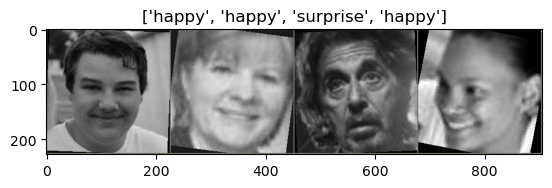

In [83]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(DataLoader(train_dataset, batch_size=4, shuffle=True)))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[emotions[x] for x in classes])


In [84]:
model = models.swin_t(weights='IMAGENET1K_V1')
model.head = nn.Linear(model.head.in_features, num_classes)
model = model.to(device)


In [85]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)


In [87]:
num_epochs = 30  # Increase the number of epochs

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in (train_dl if phase == 'train' else val_dl):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset if phase == 'train' else val_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset if phase == 'train' else val_dataset)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print('Training complete')


Epoch 0/29
----------
train Loss: 1.0870 Acc: 0.5636
val Loss: 0.7817 Acc: 0.6894
Epoch 1/29
----------
train Loss: 0.7923 Acc: 0.6967
val Loss: 0.7185 Acc: 0.7398
Epoch 2/29
----------
train Loss: 0.6546 Acc: 0.7541
val Loss: 0.6449 Acc: 0.7585
Epoch 3/29
----------
train Loss: 0.5579 Acc: 0.7883
val Loss: 0.5860 Acc: 0.8013
Epoch 4/29
----------
train Loss: 0.4876 Acc: 0.8202
val Loss: 0.4932 Acc: 0.8178
Epoch 5/29
----------
train Loss: 0.4390 Acc: 0.8359
val Loss: 0.5435 Acc: 0.8189
Epoch 6/29
----------
train Loss: 0.3833 Acc: 0.8613
val Loss: 0.5042 Acc: 0.8178
Epoch 7/29
----------
train Loss: 0.3672 Acc: 0.8632
val Loss: 0.5260 Acc: 0.8277
Epoch 8/29
----------
train Loss: 0.3313 Acc: 0.8768
val Loss: 0.4864 Acc: 0.8310
Epoch 9/29
----------
train Loss: 0.2947 Acc: 0.8907
val Loss: 0.5439 Acc: 0.8332
Epoch 10/29
----------
train Loss: 0.2603 Acc: 0.9047
val Loss: 0.5160 Acc: 0.8255
Epoch 11/29
----------
train Loss: 0.2542 Acc: 0.9070
val Loss: 0.5141 Acc: 0.8288
Epoch 12/29
--

In [88]:
torch.save(model.state_dict(), 'swin_transformer_emotion_model.pth')


In [89]:
import pandas as pd

test_dir = 'data/test'
test_files = [os.path.join(test_dir, img_file) for img_file in os.listdir(test_dir)]

test_dataset = EmotionDataset(test_files, transform=transform_val)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
results = []

for inputs in test_dl:
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        preds = preds.cpu().numpy()
        results.extend(preds)

results_df = pd.DataFrame({'Id': [os.path.basename(file) for file in test_files], 'emotions': [emotions[pred] for pred in results]})
results_df.to_csv('predictions_swin.csv', index=False)


Notes
- training on 10% eval test set with 30 epochs achieved ~81,7% Kaggle F1-score (Best model yet)
- 